# Generating names with recurrent neural networks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Our data
Датасет состоит из 8к имен, написанных латиницей.

In [3]:
start_token = " "

def read_names(path_to_file):
    global start_token
    
    with open(path_to_file) as f:
        names = f.read()[:-1].split('\n')
        names = [start_token + line for line in names]
        return names

In [4]:
try:
    names = read_names('./names')
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/names_dataset/names -nc -O names
    names = read_names('./names')

In [5]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length = 16


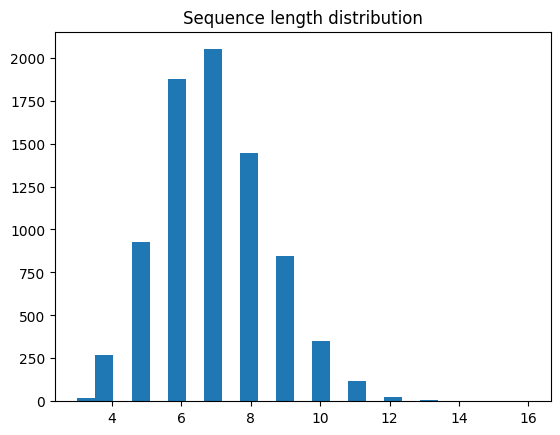

In [6]:
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=25);

# Text processing

In [ ]:
tokens = # <list of all unique characters in the dataset>

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

assert 50 < num_tokens < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

### Convert characters to integers

PyTorch умеет работать только с числами, а не со строками.
Поэтому чтобы натренировать нейросеть, необходимо сопоставить каждому токену уникальное число.

Давайте займемся созданием этого маппинга вида "токен: число"

In [ ]:
token_to_id = #<dictionary of symbol -> its identifier (index in tokens list)>

In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

In [ ]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [ ]:
names[:2]

In [ ]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

# Recurrent neural network

Мы можем переписать архитектуру нейронной сети в следующем виде: входной тензор размерности $x_t$ и тензор предыдщего состояния размера $h_t$.
<img src="https://github.com/neychev/made_nlp_course/blob/spring2021/week00_RNNs_and_Language_Models/rnn.png?raw=1" width=480>

Для тренировки языковой модели необходимо дополнить архитектуру двумя вещами:
* Добавить слой эмбеддинга, который конвертирует x_t в вектор нужной размерности.
* Выходной слой, предсказывающий вероятности следующего токена в последовательности.

In [7]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = # YOUR CODE HERE
        h_next = # YOUR CODE HERE
        
        h_next = # YOUR CODE HERE
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = # YOUR CODE
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [ ]:
char_rnn = CharRNNCell()
criterion = # YOUR CODE HERE

### RNN loop

Как только мы определили один шаг RNN, мы можем применить его в цикле, чтобы получить прогнозы для каждого шага.

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [ ]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

### Likelihood and gradients

Теперь мы можем обучить нашу нейронную сеть минимизировать кроссэнтропию (максимизировать логарифмическое правдоподобие) с фактическими следующими токенами.

Чтобы сделать это векторизованным способом, мы берем `batch_ix[:, 1:]` - матрицу идентификаторов токенов, сдвинутую на i шаг влево, так что i-й элемент фактически является «следующим токеном» для i-го прогноза.

In [ ]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

# .contiguous() method checks that tensor is stored in the memory correctly to 
# get its view of desired shape.

loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))

In [ ]:
loss.backward()

In [ ]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

### The training loop

Мы обучаем наш char-rnn точно так же, как мы обучаем любую модель глубокого обучения: с помощью мини-батч SGD.

Единственная разница в том, что на этот раз мы сэмплируем строки, а не изображения или звук.

In [ ]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

In [ ]:
MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = # YOUR CODE HERE
    actual_next_tokens = # YOUR CODE HERE

    loss = # YOUR CODE HERE
    
    # train with backprop
    # YOUR CODE HERE
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: sampling
После того, как мы немного обучили нашу сеть, давайте приступим к генерированию материала.  
Все, что нам нужно, это функция одного шага rnn, которую вы определили в `char_rnn.forward`.

In [8]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
for _ in range(10):
    print(generate_sample(char_rnn))

In [ ]:
for _ in range(50):
    print(generate_sample(char_rnn, seed_phrase=' Deb'))

### More seriously

То, что мы только что сделали, — это ручная низкоуровневая реализация RNN. Хотя это круто, я думаю, вам не понравится идея каждый раз переписывать его с нуля.

Как вы могли догадаться, у torch есть решение для этого. Чтобы быть более конкретным, есть два варианта:
* `nn.RNNCell(emb_size, rnn_num_units)` - реализует один шаг RNN, как и вы. В основном concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - реализует за вас весь rnn_loop.

Есть также «nn.LSTMCell» против «nn.LSTM», «nn.GRUCell» против «nn.GRU» и т. д. и т. д.

В этом примере мы перепишем char_rnn и rnn_loop, используя высокоуровневый API rnn.

In [ ]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [ ]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

In [ ]:
logp_seq = model(batch_ix)

loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

In [ ]:
MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    
    # compute loss
    
    # YOUR CODE HERE
    
    # train with backprop

    # YOUR CODE HERE
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### To sum up:
- PyTorch удобен как для прототипирования, так и для производства
- Много предустановленных методов/слоев/активаций из коробки
- Гораздо проще (*действительно проще*) использовать PyTorch, чем TensorFlow на начальном уровне.
- Нейронные сети - это не *черные ящики*, они довольно приятны и просты в использовании (почти всегда).

### Try it out!
Вы только что реализовали рекуррентную языковую модель, перед которой можно генерировать любую последовательность, так что есть много данных, на которых вы можете ее опробовать:

* Романы/стихи/песни вашего любимого автора
* Заголовки новостей/заголовки кликбейтов
* Исходный код Linux или Tensorflow
* Мелодия в формате нот/аккордов
* Названия каталога ИКЕА
* Имена покемонов
* Карты из Magic, the Gathering/Hearthstone

Если вы хотите попробовать, вот что вы хотите посмотреть:
* Текущий формат данных представляет собой последовательность строк, поэтому роман можно отформатировать как список предложений. Кроме того, вы можете полностью изменить предварительную обработку данных.
* Хотя некоторые наборы данных уже доступны и собраны, другие можно получить только из Интернета. Попробуйте для этого Selenium или Scrapy.
* Убедитесь, что MAX_LENGTH настроен для более длинных наборов данных.
* Более сложные задачи требуют большей архитектуры RNN, попробуйте больше нейронов или несколько слоев. Это также потребует большего количества итераций обучения.
* Долгосрочные зависимости в музыке, романах или молекулах лучше обрабатываются с помощью LSTM или GRU.